In [83]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context('notebook')

In [84]:
import sys
sys.path.append('../')
import targprop.operations as ops

In [434]:
# dimensions
n0 = 1 # input dimension / number of input units
n1 = 2 # hidden dimension / number of hidden layer units
n2 = 1

th1 = 3*np.pi/8
W1 = np.array([[np.cos(th1)], [np.sin(th1)]]) # size 2 x 1
th2 = -2*np.pi/8
W2 = np.array([[np.cos(th2) , np.sin(th2)]]) # size 1 x 2

# inputs
num_examples = 2

x0 = np.linspace(-1, 1, num_examples)[np.newaxis, :]

In [435]:
lin = ops.linear()
tanh = ops.tanh()

In [436]:
y = -0.8*x0

In [437]:
# forward pass on the model
#x1 = np.dot( W1, x0 )
#x2 = np.dot( W2, x1 )

In [438]:
def get_subspaces(A, r):
  u,s,v = np.linalg.svd(A, full_matrices=True)
  ss = {'im': u[:,:r], 'ker': v[r:].T, 'coim': v[:r].T, 'coker': u[:,r:]}
  
  ss2 = {'im':  np.dot(ss['im'], mg(ss['im'].shape[1])), 
        'ker': np.dot(ss['ker'], mg(ss['ker'].shape[1])), 
        'coim': np.dot(ss['coim'], mg(ss['coim'].shape[1])), 
        'coker': np.dot(ss['coker'], mg(ss['coker'].shape[1])), }
  return ss2

In [439]:
def mg(dim):
  if dim>0:
    return np.stack(np.meshgrid(*(dim*[np.linspace(-5, 5, 101)]))).reshape(dim, -1)
  else:
    return []

In [440]:
def train(prop_method, gamma=1, num_steps=10, alpha=0.5):
  
  layers = 2
  l_dim = [1, 2, 1]
  
  def lint():
    return [(layers+1)*[None] for i in range(num_steps)]
  
  W = lint()
  x = lint()
  L = lint()
  
  p = lint()
  
  Wt = lint()
  xt = lint()
  pt = lint()
  
  Ws = lint()

  # init
  for l in range(1, layers+1):
    W[0][l] = np.random.randn(l_dim[l], l_dim[l-1])
  

  # train
  for t in range(num_steps):

    x[t][0] = x0
    xt[t][-1] = y

    # Fw
    for l in range(1, layers+1):
      x[t][l] = lin.f( W[t][l], x[t][l-1] )

    # targs
    for l in range(layers-1, -1, -1):
      xt[t][l] = lin.f_inv( xt[t][l+1].T, x[t][l].T, W[t][l+1].T ).T

    # Bw
    p[t][-1] = -(x[t][-1] - xt[t][-1])
    for l in range(layers-1, 0, -1):
      p[t][l] = -(x[t][l] - xt[t][l]) + np.dot(W[t][l+1].T, p[t][l+1])
      
    if t < num_steps - 1:
      for l in range(1, layers+1):
        W[t+1][l] = W[t][l] + alpha*np.dot(p[t][l], x[t][l-1].T)
        
    for l in range(1, layers+1):
      L[t][l] = 0.5*np.mean((x[t][l] - xt[t][l])**2)
      
    for l in range(1, layers+1):
      Ws[t][l] = get_subspaces(W[t][l], 1)
      
  return { 'W': W, 'x': x, 'L': L, 'p': p, 'Wt': Wt, 'xt': xt, 'pt': pt, 'Ws': Ws }

In [441]:
num_steps = 2
datasets = {}
datasets['bp'] = train('bp', num_steps=num_steps, alpha=0.1)

In [442]:
def plot_loss(data, ax, label):
  ax.plot(np.log(np.stack(data['L'])[:, 1:].astype('float')), '-', label=label)

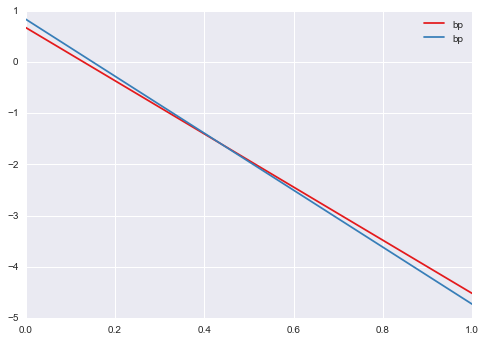

In [443]:
sns.set_palette(sns.color_palette("Set1", 10))
fig = plt.figure()
ax = fig.add_subplot(111)
for key, val in datasets.items():
  plot_loss(val, ax, key)
plt.legend()

In [444]:
def axify(ax, lims=None):
  ax.axis('equal')
  if not lims:
    lims = ax.get_xlim() + ax.get_ylim()
    lims = min(lims), max(lims)
  ax.set_xlim(lims)
  ax.set_ylim(lims)

  ax.xaxis.set_ticks(np.arange(np.floor(lims[0]), np.ceil(lims[1]), 0.5))
  ax.yaxis.set_ticks(np.arange(np.floor(lims[0]), np.ceil(lims[1]), 0.5))
  
  ax.hlines([0], *ax.get_xlim(), linewidth=0.75, alpha=0.5)
  ax.vlines([0], *ax.get_ylim(), linewidth=0.75, alpha=0.5)


In [445]:
def add_scatterplot(fig, nrows, ncols, subplot, data, args):
  
  if data.shape[0]==1:
    rng = data.max() - data.min()
    ax = fig.add_subplot(nrows, ncols, subplot)
    ax.scatter(data[0,:], rng*0.0*(np.random.rand(1, data.shape[1])-0.5), **args)
    #ax.scatter(data[0,:], np.linspace(-0.05, 0.05, data.shape[1]), **args)
    axify(ax)
    ax.set_xlim((data.min()-rng*0.1, data.max()+rng*0.1))
    ax.set_ylim((-rng*0.1, rng*0.1))
    ax.yaxis.set_ticks([0])

  elif data.shape[0]==2:
    ax = fig.add_subplot(nrows, ncols, subplot)
    ax.scatter(data[0,:], data[1,:], **args)
    axify(ax)
  elif data.shape[0]>2:
    ax = fig.add_subplot(nrows, ncols, subplot, projection='3d')
    ax.scatter(data[0,:], data[1,:], data[2,:], **args)

  return ax

In [446]:
def append_scatterplot(ax, data, args):

  if data.shape[0]==1:
    ax.scatter(data[0,:], np.zeros_like(data), **args)
  elif data.shape[0]==2:
    ax.scatter(data[0,:], data[1,:], **args)
  elif data.shape[0]>2:
    ax.scatter(data[0,:], data[1,:], data[2,:], **args)

  return ax

------------

In [447]:
cmap = sns.color_palette("coolwarm", num_examples)
set1 = sns.color_palette('Set1')

sort_inds = np.argsort(y[0])
cmap_sorted = [cmap[i] for i in np.argsort(sort_inds)]

In [448]:
ds = datasets['bp']

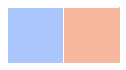

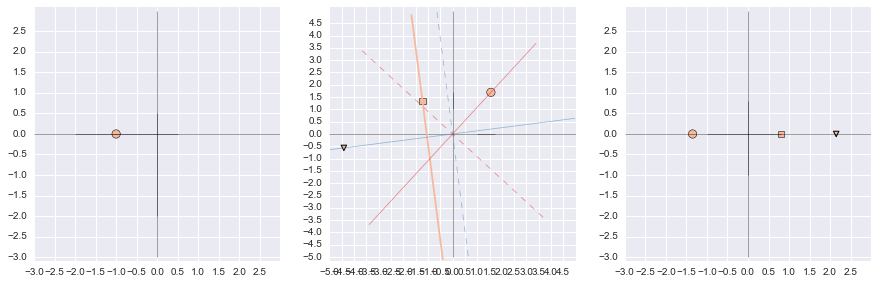

In [465]:
sns.palplot(cmap)

rows = 2
cols = 3
mult = 5

fig = plt.figure(figsize=(mult*cols, mult*rows))

args = {}
args['c'] = cmap_sorted
args['s'] = 70
args['linewidth'] = 0.5

args2 = {}
args2['c'] = cmap_sorted
args2['s'] = 40
args2['linewidth'] = 0.5
args2['marker'] = 's'

args3 = {}
args3['c'] = cmap_sorted
args3['s'] = 30
args3['linewidth'] = 1
args3['marker'] = 'v'

ax = []

t=0
ex = 0


# plot inputs
i = 0
ax.append(add_scatterplot(fig, rows, cols, i+1, x0[:,ex][:, np.newaxis], args))
axify(ax[-1], [-3,3])

i=1
ax.append(add_scatterplot(fig, rows, cols, i+1, ds['x'][t][1][:,ex][:, np.newaxis], args))
append_scatterplot(ax[-1], ds['xt'][t][1][:,ex][:, np.newaxis], args2)

for j in [ex]:
  ker = ds['Ws'][t][2]['ker']
  datpoint = np.dot(np.linalg.pinv(ds['W'][t][2]), xt[t][2][:, j])[:, np.newaxis]
  line = ker + datpoint
  plt.plot(line[0,:], line[1,:], c=cmap_sorted[j])

#ax[-1].plot(np.dot(ker, np.linspace(-5,5,101)))
ax[-1].plot(ds['Ws'][t][1]['im'][0,:],    ds['Ws'][t][1]['im'][1,:],          c=set1[0], linewidth=0.75, alpha=0.5)
ax[-1].plot(ds['Ws'][t][1]['coker'][0,:], ds['Ws'][t][1]['coker'][1,:], '--', c=set1[0], linewidth=0.75, alpha=0.5)
ax[-1].plot(ds['Ws'][t][2]['coim'][0,:],  ds['Ws'][t][2]['coim'][1,:],        c=set1[1], linewidth=0.75, alpha=0.5)
ax[-1].plot(ds['Ws'][t][2]['ker'][0,:],   ds['Ws'][t][2]['ker'][1,:],   '--', c=set1[1], linewidth=0.75, alpha=0.5)
append_scatterplot(ax[-1], ds['p'][t][1][:,ex][:, np.newaxis], args3)

axify(ax[-1], [-5,5])

i=2
ax.append(add_scatterplot(fig, rows, cols, i+1, y[:,ex][:, np.newaxis], args2))
append_scatterplot(ax[-1], ds['x'][t][2][:,ex][:, np.newaxis], args)
append_scatterplot(ax[-1], ds['p'][t][2][:,ex][:, np.newaxis], args3)


axify(ax[-1], [-3,3])

i=3

i=4
#ax.append(fig.add_subplot(rows, cols, i+1))
# ax.append(add_scatterplot(fig, rows, cols, i+1, ds['x1_est'][t], args))

# ax[-1].plot(ds['W1_ss'][t]['im'][0,:], ds['W1_ss'][t]['im'][1,:], c=sns.color_palette()[0])
# ax[-1].plot(ds['W1_ss'][t]['coker'][0,:], ds['W1_ss'][t]['coker'][1,:],'--', c=sns.color_palette()[0])
# ax[-1].plot(ds['W2_ss'][t]['coim'][0,:], ds['W2_ss'][t]['coim'][1,:], c=sns.color_palette()[1])
# ax[-1].plot(ds['W2_ss'][t]['ker'][0,:], ds['W2_ss'][t]['ker'][1,:],'--', c=sns.color_palette()[1])

# # for j in np.arange(0, num_examples, 1):
# #   ax[-1].plot(x1_tar[0,:,j], x1_tar[1,:,j], c=cmap_sorted[j])
# axify(ax[-1], [-3, 3])

# i=5
# ax.append(add_scatterplot(fig, rows, cols, i+1, y, args))
# axify(ax[-1], [-3,3])


In [458]:
x0[:,0]

array([-1.])

In [451]:
ds['p'][0][2]

array([[ 2.14999422, -2.14999422]])

In [389]:
ds['W'][0][2]

array([[-1.23200951,  0.50923443]])

In [366]:
ker.shape

(2, 101)

In [367]:
np.dot(np.linalg.pinv(ds['W'][t][2]), xt[t][2][:, j])[:, np.newaxis]

array([[ 0.55459477],
       [-0.22923423]])

In [353]:
np.dot( np.linalg.pinv(ds['W'][t][2]), xt[t][2][:, j] )[:, np.newaxis]

array([[-0.55459477],
       [ 0.22923423]])

In [343]:
ker

array([[-1.90995716, -1.87175802, -1.83355888, -1.79535973, -1.75716059,
        -1.71896145, -1.6807623 , -1.64256316, -1.60436402, -1.56616487,
        -1.52796573, -1.48976659, -1.45156744, -1.4133683 , -1.37516916,
        -1.33697001, -1.29877087, -1.26057173, -1.22237258, -1.18417344,
        -1.1459743 , -1.10777515, -1.06957601, -1.03137687, -0.99317772,
        -0.95497858, -0.91677944, -0.87858029, -0.84038115, -0.80218201,
        -0.76398286, -0.72578372, -0.68758458, -0.64938544, -0.61118629,
        -0.57298715, -0.53478801, -0.49658886, -0.45838972, -0.42019058,
        -0.38199143, -0.34379229, -0.30559315, -0.267394  , -0.22919486,
        -0.19099572, -0.15279657, -0.11459743, -0.07639829, -0.03819914,
         0.        ,  0.03819914,  0.07639829,  0.11459743,  0.15279657,
         0.19099572,  0.22919486,  0.267394  ,  0.30559315,  0.34379229,
         0.38199143,  0.42019058,  0.45838972,  0.49658886,  0.53478801,
         0.57298715,  0.61118629,  0.64938544,  0.6

In [337]:
ds['p'][0][1]

array([[-3.96697042,  3.96697042],
       [ 1.63969345, -1.63969345]])

In [73]:
ds['W1_ss'][0]['im']

(2, 101)